In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import string

%load_ext blackcellmagic

In [2]:
data_folder = "data/years/"

file_list = [
    f
    for f in listdir(data_folder)
    if isfile(join(data_folder, f)) and f.endswith(".json")
]

dfs = []  # an empty list to store the data frames
for file in file_list:
    path = data_folder + file
    data = pd.read_json(path)  # read data frame from json file
    dfs.append(data)  # append the data frame to the list

music_data = pd.concat(
    dfs, ignore_index=True
)  # concatenate all the data frames in the list.

In [3]:
music_data.head(2)

,lyrics,tags,num_syllables,pos,year,fog_index,flesch_index,num_words,num_lines,sentiment,title,f_k_grade,artist,difficult_words,num_dupes
0,"Mona Lisa, Mona Lisa, men have named you\nYou'...","[american, death by lung cancer, easy listenin...",189.0,2,1950,5.2,88.74,145,17,"{'neg': 0.155, 'neu': 0.646, 'pos': 0.199, 'co...",Mona Lisa,2.9,Nat King Cole,13,10
1,I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...,[andrews sisters],270.9,17,1950,4.4,82.31,189,31,"{'neg': 0.036000000000000004, 'neu': 0.74, 'po...",I Wanna Be Loved,3.3,Andrews Sisters,40,32


In [4]:
print(f"There are {len(music_data)} songs.")

There are 4028 songs.


In [5]:
music_data.groupby("year")[["lyrics"]].count().describe()

,lyrics
count,66.000000
mean,61.030303
std,20.331082
min,6.000000
25%,54.250000
50%,68.000000
75%,76.000000
max,82.000000


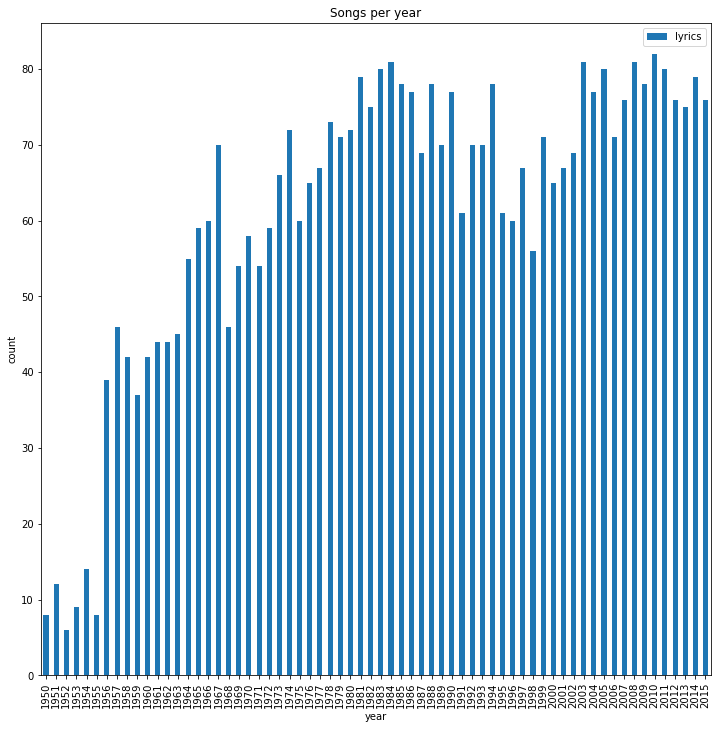

In [6]:
music_data.groupby("year")[["lyrics"]].count().plot(
    kind="bar", figsize=(12, 12), title="Songs per year"
)
plt.ylabel("count")
plt.xlabel("year")
plt.show()

The means for the negative, positive and neutral songs are respectively: 0.0743, 0.156 and 0.769.


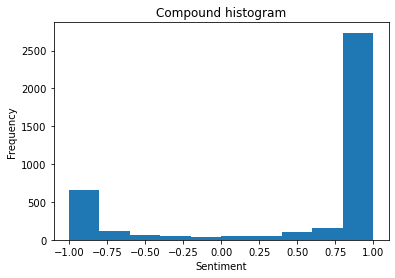

In [7]:
neg_mean = music_data.sentiment.map(lambda dic: dic["neg"]).mean()
pos_mean = music_data.sentiment.map(lambda dic: dic["pos"]).mean()
neutral_mean = music_data.sentiment.map(lambda dic: dic["neu"]).mean()
print(
    f"The means for the negative, positive and neutral songs are respectively: {neg_mean:.3}, {pos_mean:.3} and {neutral_mean:.3}."
)
music_data.sentiment.map(lambda dic: dic["compound"]).plot(kind="hist")
plt.title("Compound histogram")
plt.xlabel("Sentiment")
plt.show()

In [8]:
print(
    f"There are {len(set([element for list_ in list(music_data.tags) for element in list_]))} tags."
)

There are 966 tags.


In [9]:
print(f"There are {len(music_data['artist'].drop_duplicates())} artists.")

There are 1308 artists.


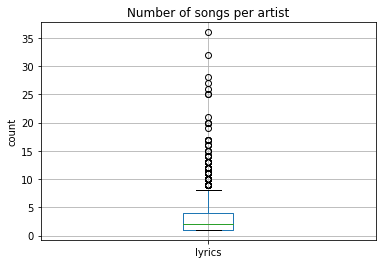

In [10]:
music_data.groupby("artist")[["lyrics"]].count().boxplot()
plt.title("Number of songs per artist")
plt.ylabel("count")
# plt.yscale('log')
plt.show()

In [11]:
small_set_colors = set(
    [
        "white",
        "black",
        "yellow",
        "green",
        "purple",
        "brown",
        "pink",
        "red",
        "blue",
        "maroon",
        "salmon",
        "coral",
        "orange",
        "gold",
        "silver",
        "lime",
        "turquoise",
        "cyan",
        "navy",
        "indigo",
        "magenta",
        "beige",
        "tan",
        "grey",
    ]
)

In [12]:
with open("colors.txt", "r") as file_colors:
    set_colors = set([line.strip() for line in file_colors])

In [13]:
print(
    f"The small set of colors contains {len(small_set_colors)} colors and the big one contains {len(set_colors)} colors."
)

The small set of colors contains 24 colors and the big one contains 229 colors.


In [14]:
music_data["small_intersection_colors_title"] = (
    music_data["title"]
    .str.lower()
    .map(
        lambda title: set(
            title.translate(str.maketrans("", "", string.punctuation)).split()
        ).intersection(small_set_colors)
    )
)
music_data["small_intersection_colors_lyrics"] = (
    music_data["lyrics"]
    .str.lower()
    .map(
        lambda lyrics: set(
            lyrics.translate(str.maketrans("", "", string.punctuation)).split()
        ).intersection(small_set_colors)
    )
)

music_data["intersection_colors_title"] = (
    music_data["title"]
    .str.lower()
    .map(
        lambda title: set(
            title.translate(str.maketrans("", "", string.punctuation)).split()
        ).intersection(set_colors)
    )
)
music_data["intersection_colors_lyrics"] = (
    music_data["lyrics"]
    .str.lower()
    .map(
        lambda lyrics: set(
            lyrics.translate(str.maketrans("", "", string.punctuation)).split()
        ).intersection(set_colors)
    )
)

In [15]:
small_colored_songs = music_data[
    music_data["small_intersection_colors_lyrics"] != set()
]
colored_songs = music_data[music_data["intersection_colors_lyrics"] != set()]

small_colored_titles = music_data[
    music_data["small_intersection_colors_title"] != set()
]
colored_titles = music_data[music_data["intersection_colors_title"] != set()]

In [16]:
print(
    f"There are {len(small_colored_titles)} songs with colors in their lyrics using the small set of colors and\n there are {len(colored_titles)} songs with colors in their lyrics using the big set of colors."
)

print(
    f"There are {len(small_colored_songs)} songs with colors in their lyrics using the small set of colors and\n there are {len(colored_songs)} songs with colors in their lyrics using the big set of colors."
)

There are 59 songs with colors in their lyrics using the small set of colors and
 there are 144 songs with colors in their lyrics using the big set of colors.
There are 780 songs with colors in their lyrics using the small set of colors and
 there are 1741 songs with colors in their lyrics using the big set of colors.


In [17]:
color_counts = (
    pd.DataFrame(
        [
            color
            for colors_list in list(
                small_colored_songs["small_intersection_colors_lyrics"].map(lambda set_: list(set_))
            )
            for color in colors_list
        ],
        columns=["color"],
    )
    .reset_index()
    .groupby("color")
    .count()
    .rename(columns={'index' : 'count'})
)

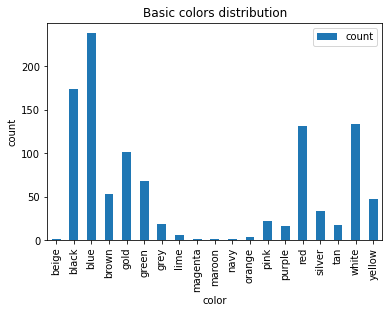

In [18]:
color_counts.plot(kind='bar')
plt.title("Basic colors distribution")
plt.ylabel('count')
plt.show()